In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv(r"C:\Users\22303\Desktop\6013小组作业\dataset.csv")

In [3]:
from imblearn.over_sampling import SMOTE

# 分离特征（X）和标签（y）
X = df.drop("loan_status", axis=1)  # 特征列
y = df["loan_status"]  # 标签列

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514, stratify=y)

# 初始化SMOTE过采样器
smote = SMOTE(random_state=114514)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 查看采样后的数据分布
print("\n采样后训练集标签分布：")
print(y_train.value_counts())

# 合并训练集特征（X_train）和标签（y_train）
train_set = pd.concat([X_train, y_train], axis=1)

# 合并测试集特征（X_test）和标签（y_test）
test_set = pd.concat([X_test, y_test], axis=1)


采样后训练集标签分布：
loan_status
0.0    1570803
1.0    1570803
Name: count, dtype: int64


In [4]:
# 初始化 XGBoost 分类器
model = xgb.XGBClassifier(
    objective="binary:logistic", # 二分类目标函数（返回正类概率）
    max_depth=3,                 # 树深度
    learning_rate=0.1,           # 学习率
    subsample=0.8,               # 样本采样比例
    colsample_bytree=0.8,        # 特征采样比例
    gamma=0.1,                   # 分裂最小损失减少量（正则化）
    reg_alpha=0.1,               # L1 正则
    reg_lambda=1.0,              # L2 正则
    eval_metric="logloss",       # 二分类评价指标
    n_estimators=100,            # 最大树数量（对应 num_boost_round）
    random_state=114514,         # 随机种子
    n_jobs=-1,                   # 并行计算（使用所有 CPU 核心）
    verbosity=1                  # 打印日志级别（0=静默，1=警告，2=详细）
)

# 训练模型
model.fit(
    X_train, y_train,
    verbose=True                 # 打印每轮性能
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [5]:
# 预测类别
y_pred = model.predict(X_test)

# 预测类别概率
y_pred_prob = model.predict_proba(X_test)

In [6]:
# 评估指标
print("\n" + "="*50)
print("模型评估结果（基于 test_set）：")
print(f"测试集准确率：{accuracy_score(y_test, y_pred):.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names = ['不违约', '违约']))
print("\n混淆矩阵：")
print(confusion_matrix(y_test, y_pred))
print("="*50)


模型评估结果（基于 test_set）：
测试集准确率：0.7931

分类报告：
              precision    recall  f1-score   support

         不违约       0.90      0.86      0.88    392701
          违约       0.27      0.36      0.31     58013

    accuracy                           0.79    450714
   macro avg       0.59      0.61      0.59    450714
weighted avg       0.82      0.79      0.80    450714


混淆矩阵：
[[336697  56004]
 [ 37258  20755]]


In [7]:
# 模型指标与实验结果评估
# 1. 整体性能表现：
#    模型在测试集上的整体准确率达到0.7931，
#    表明在贷款状态预测任务中具有一定分类能力，
#    但存在明显的性能不均衡问题。

# 2. 类别级性能分析：
#    由于数据集存在显著类别不平衡（负类样本392701个，
#    正类样本仅58013个），模型对多数类（负类）的预测性能
#    远优于少数类（正类）。
#    - 负类：精确率0.90、召回率0.86、F1分数0.88，分类效果优秀；
#    - 正类：精确率仅0.27、召回率0.36、F1分数0.31，
#      无法有效捕捉少数类样本，存在严重偏向性。

# 3. 混淆矩阵解读：
#    混淆矩阵显示具体分类结果存在较多误判：
#    - 负类中，336697个样本被正确预测，56004个被误判为正类（假阳性）；
#    - 正类中，仅20755个被正确预测，37258个被误判为负类（假阴性）。
#    若应用于贷款审批场景，假阴性可能导致优质申请被驳回，
#    假阳性可能导致高风险申请通过，影响业务决策合理性。

# 4. 实验效果总结：
#    SMOTE过采样技术虽平衡了训练集类别分布，但未显著改善少数类预测性能。

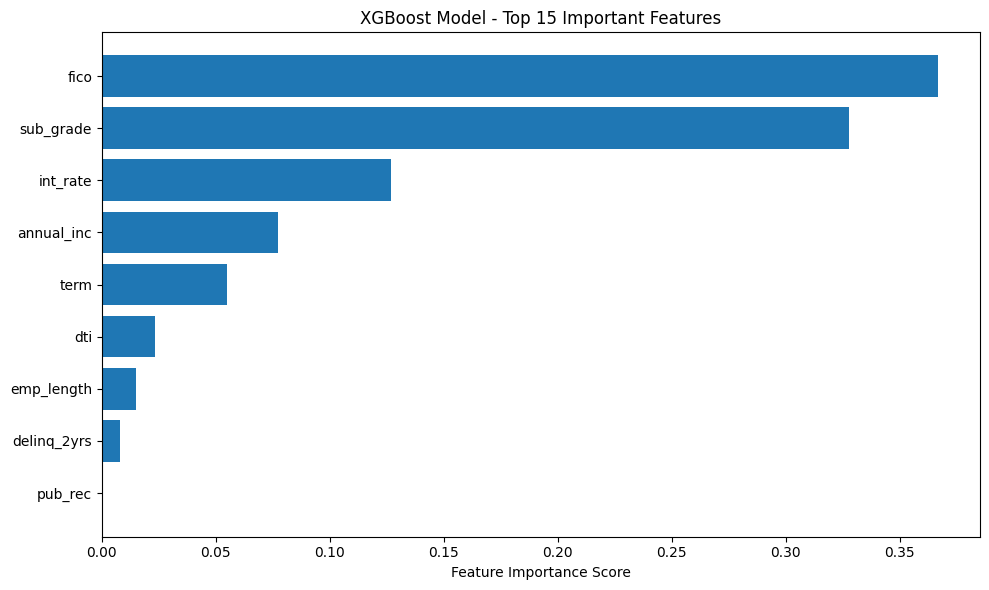

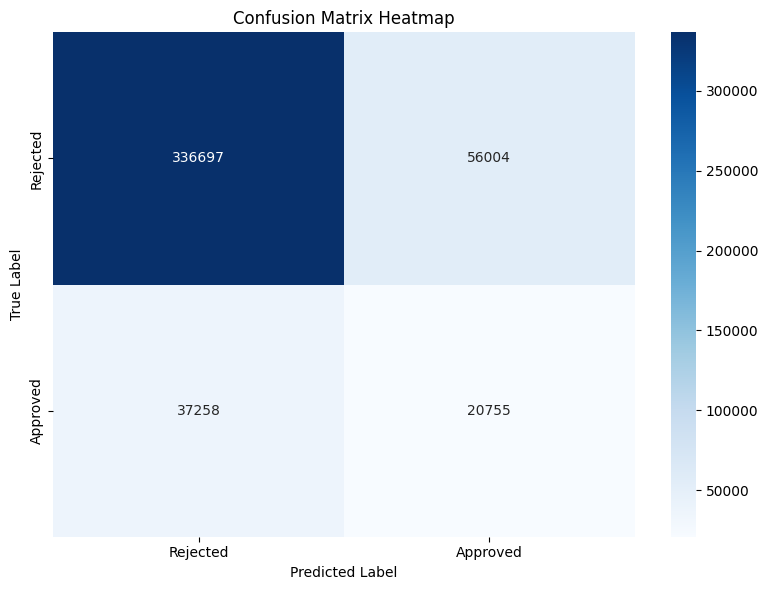

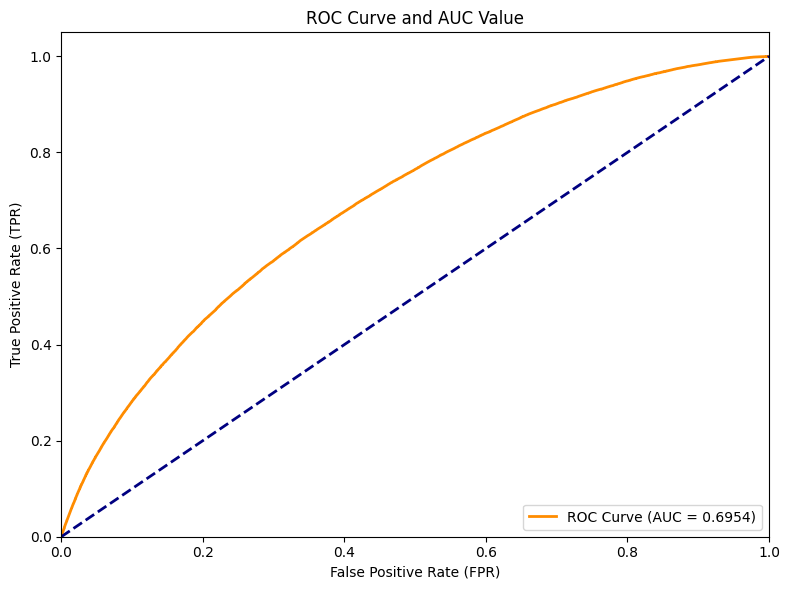

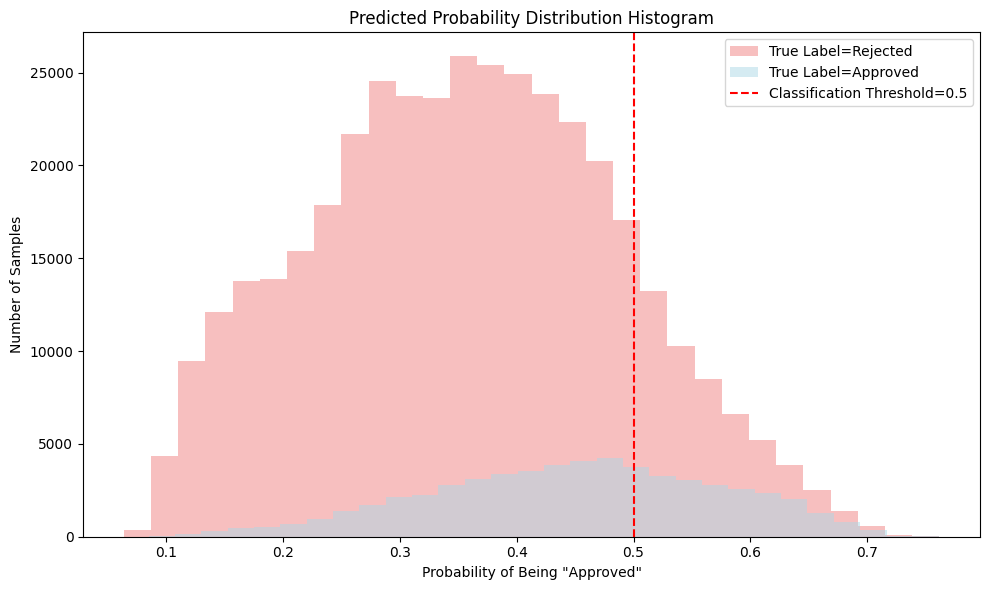

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# ========== 1. Feature Importance Plot ==========
plt.figure(figsize=(10, 6))
# Assume 'model' is your trained model (e.g., XGBClassifier, RandomForestClassifier)
# Replace with your actual feature importance extraction method if needed
feature_importance = model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[-15:]  
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('XGBoost Model - Top 15 Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 2. Confusion Matrix Heatmap ==========
plt.figure(figsize=(8, 6))
# Assume 'y_test' is your true labels and 'y_pred' is your predicted labels
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'], 
            yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 3. ROC Curve ==========
plt.figure(figsize=(8, 6))
# Assume 'y_pred_prob' is your predicted probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve and AUC Value')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 4. Predicted Probability Distribution Histogram ==========
plt.figure(figsize=(10, 6))
plt.hist(y_pred_prob[y_test == 0][:, 1], bins=30, alpha=0.5, label='True Label=Rejected', color='lightcoral')
plt.hist(y_pred_prob[y_test == 1][:, 1], bins=30, alpha=0.5, label='True Label=Approved', color='lightblue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Classification Threshold=0.5')
plt.xlabel('Probability of Being "Approved"')
plt.ylabel('Number of Samples')
plt.title('Predicted Probability Distribution Histogram')
plt.legend()
plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()